# Imports + Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm


all_data = pd.read_csv('SPAE/MITU0031_OUTPUT2.csv').dropna()

# Preprocessing: convert Zip to Congressional District
zip2cd = pd.read_csv('CD_ZIP_062021.csv')

all_data['district'] = all_data['inputzip'].apply(lambda zip: list(zip2cd[zip2cd['zip'] == zip]['cd']))
all_data['district'] = all_data[all_data['district'].map(lambda d: len(d)) > 0]['district'].apply(lambda x: str(x[0]))

all_data['district'] = all_data['district'].apply(lambda x: str(x))
all_data = all_data[all_data['district'] != 'nan']

States = sorted(['Alabama', 'Alaska', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin', 'West Virginia', 'Wyoming'])

## Creating codes list to match MIT data
removals = [3,7,14,43,52]
codes = set([1 + i for i in list(range(56))])

for removal in removals:
    codes.remove(removal)
codes = list(codes)

states_dict = {}
for i in range(len(States)):
    states_dict[str(codes[i])] = States[i]

all_data['state'] = all_data['district'].apply(lambda x: states_dict[x[:-2]])

metrics = ['conf_vte','conf_cty','conf_ste','conf_ntl']
renaming_dict = {'Q44': 'conf_vte', 'Q45': 'conf_cty', 'Q46': 'conf_ste', 'Q47': 'conf_ntl', 'Q47B': 'fairness'}

all_data = all_data.rename(columns=renaming_dict)

# drop 'i don't know' and 'not asked'
for var in metrics:
    all_data = all_data[all_data[var]<9]
    all_data.dropna()
    all_data[var] = (max(all_data[var]) - all_data[var])/max(all_data[var])

c:\Users\nishd\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Gather election victory data by district
house_races = pd.read_csv('1976-2020-house.csv')
house_races = house_races[house_races['year'] == 2020][['state_po','state_fips','district','candidate','candidatevotes','totalvotes','party']].sort_values(by=['state_po','district']).rename(columns={'district':'just_district'})
house_races['district'] = house_races.apply(lambda row: str(row['state_fips'])+str(f"{row['just_district']:02}"), axis=1)

districts_list = list(house_races['district'].unique())
margins_df = pd.DataFrame(index=districts_list, columns=['abs_margin', 'margin', "party"])
for district in districts_list:
    race = house_races[house_races['district'] == district].sort_values(by='candidatevotes', ascending=False).iloc[:2,:]
    if len(race) == 1:
        margin = 100
        party = race.iloc[0,:]['party']
    else:
        margin = (race.iloc[0,:]['candidatevotes'] - race.iloc[1,:]['candidatevotes']) / race.iloc[0,:]['totalvotes']*100
        party = race.iloc[0,:]['party']

    if party == "REPUBLICAN":
        dir_margin = 1 * margin
    elif party == "DEMOCRAT":
        dir_margin = -1 * margin
    else:
        dir_margin = None

    margins_df.loc[district,:]=[margin,dir_margin,party]

def margin(district, value):
    try: return margins_df.loc[district,value]
    except: return None

# Add margin data to all_data
for value in margins_df.columns:
    all_data[value] = all_data['district'].apply(lambda district: margin(district, value))

## Grouping by District

In [3]:
districts_list_updated = districts_list.copy()

data_by_district = {}

for district in districts_list:
    if len(all_data[all_data['district'] == str(district)]) > 0:
        data_by_district[str(district)] = all_data[all_data['district'] == str(district)]
    else:
        districts_list_updated.remove(district)

districts_list = districts_list_updated.copy()

In [4]:
## Group data by congressional district
all_districts = pd.DataFrame(index = districts_list)

for district in districts_list:
    state = states_dict[str(data_by_district[district]['inputstate'].iloc[0])]

    all_districts.loc[district,'district'] = district
    all_districts.loc[district,'abs_margin'] = margins_df.loc[district,'abs_margin']
    all_districts.loc[district,'margin'] = margins_df.loc[district,'margin']
    all_districts.loc[district,'party'] = margins_df.loc[district,'party']
    all_districts.loc[district,'sample_size'] = len(data_by_district[district])
    all_districts.loc[district,'state'] = state

    for metric in metrics:
        avg = data_by_district[district][metric].dot(data_by_district[district]['weight'])/sum(data_by_district[district]['weight'])
        all_districts.loc[district,metric] = avg

        district_dems = data_by_district[district][data_by_district[district]['pid3'] == 1]

        district_reps = data_by_district[district][data_by_district[district]['pid3'] == 2]

        avg = district_dems[metric].dot(district_dems['weight'])/sum(district_dems['weight'])
        all_districts.loc[district,metric+'D'] = avg

        avg = district_reps[metric].dot(district_reps['weight'])/sum(district_reps['weight'])
        all_districts.loc[district,metric+'R'] = avg


C:\Users\nishd\AppData\Local\Temp/ipykernel_24308/2621005914.py:22: RuntimeWarning: invalid value encountered in double_scalars
  avg = district_dems[metric].dot(district_dems['weight'])/sum(district_dems['weight'])
C:\Users\nishd\AppData\Local\Temp/ipykernel_24308/2621005914.py:25: RuntimeWarning: invalid value encountered in double_scalars
  avg = district_reps[metric].dot(district_reps['weight'])/sum(district_reps['weight'])


In [5]:
print(pd.DataFrame([all_data[metrics].mean(),all_data[metrics].std()]).to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  conf\_vte &  conf\_cty &  conf\_ste &  conf\_ntl \\
\midrule
0 &  0.643473 &  0.614651 &  0.570123 &  0.460320 \\
1 &  0.188286 &  0.206748 &  0.240592 &  0.301993 \\
\bottomrule
\end{tabular}



##### Correlation between Trust at Different levels of government

In [6]:
from scipy.stats import kendalltau as tau


def calculate_pvalues(df,regression):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(regression(df[r], df[c])[1], 4)
    return pvalues

In [7]:
def calculate_tau(df):
    print(df[metrics].corr(method='kendall').to_latex(caption='Kendall Tau correlation of vote confidence -- XXXXXXXXXX'))

    print(calculate_pvalues(df[metrics], tau))#.to_latex()

    print('\n')
    print(len(df))

In [8]:
democrats = all_data[all_data['pid3'] == 1]
republicans = all_data[all_data['pid3'] == 2]
independents = all_data[all_data['pid3'] == 3]

democrats_lost = democrats[democrats['margin'] < 0]
republicans_lost = republicans[republicans['margin'] > 0]


In [9]:
print('DEMOCRATS')
calculate_tau(democrats)
print('REPUBLICANS')
calculate_tau(republicans)
print('INDEPENDENTS')
calculate_tau(independents)


DEMOCRATS
\begin{table}
\centering
\caption{Kendall Tau correlation of vote confidence -- XXXXXXXXXX}
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_vte &  conf\_cty &  conf\_ste &  conf\_ntl \\
\midrule
conf\_vte &  1.000000 &  0.651802 &  0.531477 &  0.434981 \\
conf\_cty &  0.651802 &  1.000000 &  0.660406 &  0.518791 \\
conf\_ste &  0.531477 &  0.660406 &  1.000000 &  0.573593 \\
conf\_ntl &  0.434981 &  0.518791 &  0.573593 &  1.000000 \\
\bottomrule
\end{tabular}
\end{table}

         conf_vte conf_cty conf_ste conf_ntl
conf_vte      0.0      0.0      0.0      0.0
conf_cty      0.0      0.0      0.0      0.0
conf_ste      0.0      0.0      0.0      0.0
conf_ntl      0.0      0.0      0.0      0.0


6228
REPUBLICANS
\begin{table}
\centering
\caption{Kendall Tau correlation of vote confidence -- XXXXXXXXXX}
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_vte &  conf\_cty &  conf\_ste &  conf\_ntl \\
\midrule
conf\_vte &  1.000000 &  0.681478 &  0.539632 &  0.274663 \\
conf\_cty &  0.68147

In [10]:
print('DEMOCRATS LOST')
calculate_tau(democrats_lost)
print('REPUBLICANS LOST')
calculate_tau(republicans_lost)

DEMOCRATS LOST
\begin{table}
\centering
\caption{Kendall Tau correlation of vote confidence -- XXXXXXXXXX}
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_vte &  conf\_cty &  conf\_ste &  conf\_ntl \\
\midrule
conf\_vte &  1.000000 &  0.639824 &  0.537227 &  0.434895 \\
conf\_cty &  0.639824 &  1.000000 &  0.681156 &  0.519555 \\
conf\_ste &  0.537227 &  0.681156 &  1.000000 &  0.558440 \\
conf\_ntl &  0.434895 &  0.519555 &  0.558440 &  1.000000 \\
\bottomrule
\end{tabular}
\end{table}

         conf_vte conf_cty conf_ste conf_ntl
conf_vte      0.0      0.0      0.0      0.0
conf_cty      0.0      0.0      0.0      0.0
conf_ste      0.0      0.0      0.0      0.0
conf_ntl      0.0      0.0      0.0      0.0


3340
REPUBLICANS LOST
\begin{table}
\centering
\caption{Kendall Tau correlation of vote confidence -- XXXXXXXXXX}
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_vte &  conf\_cty &  conf\_ste &  conf\_ntl \\
\midrule
conf\_vte &  1.000000 &  0.692895 &  0.533323 &  0.241353 \\
conf\_cty 

##### Regressions between Winner (Margin of Victory) & (Weighted mean) Trust
- Cts / Cts => Pearson Regression

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [12]:
all_data['abs_margin']

2         26.768022
3        100.000000
4          7.552275
6         32.560410
7         21.848687
            ...    
17991      9.137372
17992     38.546991
17993      9.137372
17997     61.910030
17998     38.546991
Name: abs_margin, Length: 15726, dtype: float64

In [13]:
all_data = all_data[all_data['pid7'] < 8]
all_data['party_affiliation'] = all_data['pid7']

all_data = all_data[all_data['Q4'] < 9]
all_data['votebymail'] = all_data['Q4'].apply(lambda x: 1 if x == 3 else 0)

all_data = all_data[all_data['Q47A'] < 99]
all_data['positive_experience'] = all_data.Q47A.apply(lambda x: (max(all_data.Q47A) - x)/max(all_data.Q47A))

all_data['abs_margin']


all_data = all_data[all_data['faminc_new'] < 97]
all_data['income'] = all_data['faminc_new']

all_data['race'] = all_data['race']

def won(party, margin):
    if ((margin < 0) and (party == 1)) or ((margin > 0) and (party == 2)):
        return 1
    else: return 0

all_data = all_data[all_data['pid3'] < 3]
all_data['winner'] = all_data[['pid3','margin']].apply(lambda row: won(row[0], row[1]), axis=1)

In [14]:
regressions = []
for metric in metrics:
    mod = smf.ols(metric + ' ~ pid7 + winner + abs_margin + positive_experience + income + gender', data=all_data)
    regressions.append(mod.fit())

print(summary_col(regressions,stars=True,float_format='%0.5f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}).as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                     & conf\_vte   & conf\_cty   & conf\_ste   & conf\_ntl    \\
\hline
Intercept            & -0.23504*** & -0.21532*** & -0.26597*** & 0.15564**    \\
                     & (0.05827)   & (0.06259)   & (0.07117)   & (0.07089)    \\
pid7                 & -0.02434*** & -0.03221*** & -0.04238*** & -0.08059***  \\
                     & (0.00063)   & (0.00068)   & (0.00077)   & (0.00077)    \\
winner               & 0.01969***  & 0.03690***  & 0.03614***  & -0.01753***  \\
                     & (0.00346)   & (0.00371)   & (0.00422)   & (0.00421)    \\
abs\_margin          & 0.00007     & 0.00013     & 0.00039***  & -0.00017*    \\
                     & (0.00008)   & (0.00009)   & (0.00010)   & (0.00010)    \\
positive\_experience & 0.97315***  & 0.95176***  & 0.97635***  & 0.62540***   \\
                     & (0.05898)   & (0.06335)   & (0.07203)   & (0.07176)    \\
income               & 

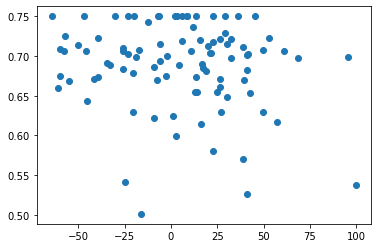

In [15]:
sample = all_districts.sample(100)
plt.scatter(sample['margin'],sample['conf_ctyD'])

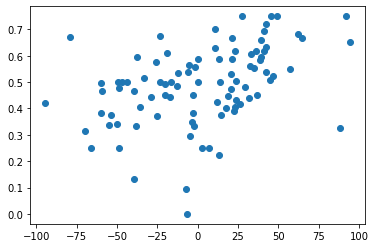

In [16]:
sample = all_districts.sample(100)
plt.scatter(sample['margin'],sample['conf_ctyR'])

Text(0.5, 0.98, 'Regional Confidence as function of Margin')

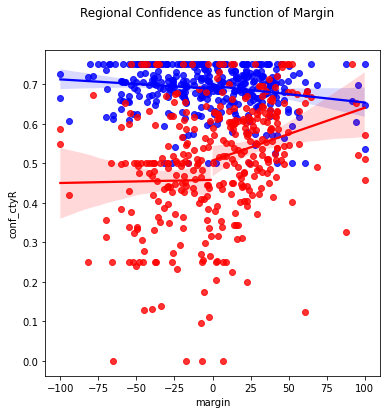

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))

sample = all_districts[all_districts['margin'] < 0].sample(200)[['margin','conf_ctyD']]
sns.regplot(x='margin',y='conf_ctyD',data = sample, color='blue')

sample = all_districts[all_districts['margin'] > 0].sample(200)[['margin','conf_ctyD']]
sns.regplot(x='margin',y='conf_ctyD',data = sample, color='blue')

sample = all_districts[all_districts['margin'] > 0].sample(200)[['margin','conf_ctyR']]
sns.regplot(x='margin',y='conf_ctyR',data = sample, color='red')

sample = all_districts[all_districts['margin'] < 0].sample(200)[['margin','conf_ctyR']]
sns.regplot(x='margin',y='conf_ctyR',data = sample, color='red')

fig.suptitle('Regional Confidence as function of Margin')

In [18]:

regressions = []
for metric in metrics:
    mod = smf.ols(metric + ' ~ dir_margin + margin', data=all_districts)
    regressions.append(mod.fit())

print(summary_col(regressions,stars=True,float_format='%0.5f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}).as_latex())

PatsyError: Number of rows mismatch between data argument and dir_margin (427 versus 1)
    conf_vte ~ dir_margin + margin
               ^^^^^^^^^^

In [26]:
dir_margin

42.78445833617591

In [19]:
regressions = []
for metric in metrics:
    mod = smf.ols(metric + ' ~ '+ ' + '.join(metrics), data=all_data)
    regressions.append(mod.fit())

print(summary_col(regressions,stars=True,float_format='%0.5f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}))


                conf_vte    conf_cty    conf_ste    conf_ntl 
-------------------------------------------------------------
Intercept      0.00000*** 0.00000***  0.00000***  0.00000*** 
               (0.00000)  (0.00000)   (0.00000)   (0.00000)  
conf_vte       1.00000*** -0.00000*** -0.00000**  0.00000*** 
               (0.00000)  (0.00000)   (0.00000)   (0.00000)  
conf_cty       -0.00000   1.00000***  -0.00000*** -0.00000***
               (0.00000)  (0.00000)   (0.00000)   (0.00000)  
conf_ste       0.00000    -0.00000    1.00000***  0.00000*** 
               (0.00000)  (0.00000)   (0.00000)   (0.00000)  
conf_ntl       0.00000    -0.00000    0.00000     1.00000*** 
               (0.00000)  (0.00000)   (0.00000)   (0.00000)  
R-squared      1.00000    1.00000     1.00000     1.00000    
R-squared Adj. 1.00000    1.00000     1.00000     1.00000    
N              9574       9574        9574        9574       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [20]:
dem_districts = all_districts[all_districts['margin'] < 0]
rep_districts = all_districts[all_districts['margin'] > 0]

<AxesSubplot:xlabel='abs_margin', ylabel='conf_ntl'>

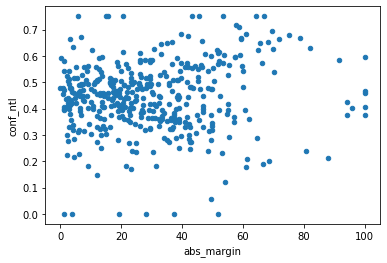

In [21]:
all_districts.plot.scatter('abs_margin', 'conf_ntl')

<AxesSubplot:xlabel='margin', ylabel='conf_ntl'>

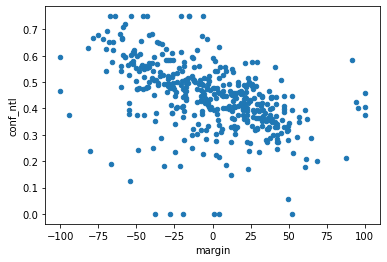

In [23]:
all_districts.plot.scatter('margin', 'conf_ntl')

In [24]:

from statsmodels.formula.api import ols


model = ols("conf_ntl ~ dir_margin", data=all_districts).fit()
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

PatsyError: Number of rows mismatch between data argument and dir_margin (427 versus 1)
    conf_ntl ~ dir_margin
               ^^^^^^^^^^

<AxesSubplot:xlabel='margin', ylabel='conf_ntl'>

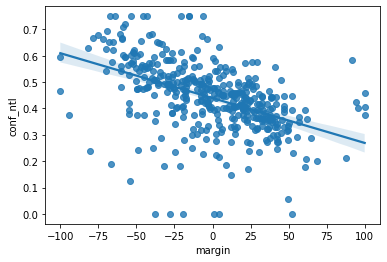

In [25]:
import seaborn as sns

sns.regplot(x='margin', y='conf_ntl', data=all_districts)